# Klotz curve

Inlate a geometry to a pressure using different
material models, and compare with the Klotz curve.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pulse

try:
    from dolfin_adjoint import Constant, DirichletBC
except ImportError:
    from dolfin import Constant, DirichletBC

In [2]:
geometry = pulse.HeartGeometry.from_file(pulse.mesh_paths["simple_ellipsoid"])
geometry.mesh.coordinates()[:] *= 3.15
ED_pressure = 1.6  # kPa

2021-05-11 20:22:52,305 - pulse.geometry_utils - INFO - 
Load mesh from h5


In [3]:
def setup_material(material_model):
    """
    Choose parameters based on

    Hadjicharalambous, Myrianthi, et al. "Analysis of passive
    cardiac constitutive laws for parameter estimation using 3D
    tagged MRI." Biomechanics and modeling in mechanobiology 14.4
    (2015): 807-828.

    These parameters did not really match the Klotz curve here.
    Perhaps they did some more tuning?

    """
    if material_model == "guccione":

        matparams = pulse.Guccione.default_parameters()
        matparams["C"] = 0.18  # kPa
        matparams["bf"] = 27.75
        matparams["bt"] = 5.37
        matparams["bfs"] = 2.445
        material = pulse.Guccione(
            parameters=matparams, f0=geometry.f0, s0=geometry.s0, n0=geometry.n0
        )

    elif material_model == "neo_hookean":

        matparams = pulse.NeoHookean.default_parameters()
        matparams["mu"] = 10.0  # kPa
        material = pulse.NeoHookean(parameters=matparams)

    elif material_model == "holzapfel_ogden":

        matparams = pulse.HolzapfelOgden.default_parameters()

        matparams["a"] = 4.0  # kPa
        matparams["a_f"] = 10.0  # kPa
        matparams["b"] = 5.0
        matparams["b_f"] = 5.0
        material = pulse.HolzapfelOgden(
            parameters=matparams, f0=geometry.f0, s0=geometry.s0, n0=geometry.n0
        )
    return material

In [4]:
def klotz_curve():
    """

    EDPVR based on Klotz curve

    Klotz, Stefan, et al. "Single-beat estimation of end-diastolic
    pressure-volume relationship: a novel method with potential for
    noninvasive application." American Journal of Physiology-Heart and
    Circulatory Physiology 291.1 (2006): H403-H412.

    """

    # Some point at the EDPVR line
    Vm = 148.663
    Pm = ED_pressure

    # Some constants
    An = 27.8
    Bn = 2.76

    # kpa to mmhg
    Pm = Pm * 760 / 101.325

    V0 = Vm * (0.6 - 0.006 * Pm)
    V30 = V0 + (Vm - V0) / (Pm / An) ** (1.0 / Bn)

    beta = math.log(Pm / 30.0) / math.log(Vm / V30)
    alpha = 30.0 / V30 ** beta

    # Unloaded volume (not used here)
    # P_V0 = alpha * V0 ** beta

    vs = [V0]
    ps = [0.0]
    for p in np.linspace(1.0, 12.0):
        vi = (p / alpha) ** (1.0 / beta)
        vs.append(vi)
        ps.append(p * 101.325 / 760)  # Convert from mmhg to kPa

    return vs, ps

2021-05-11 20:23:20,873 - pulse.iterate - INFO - Iterating....
2021-05-11 20:23:20,874 - pulse.iterate - INFO - Current control: 0.000
2021-05-11 20:23:20,875 - pulse.iterate - INFO - Target: 0.178
2021-05-11 20:23:31,082 - pulse.iterate - INFO - Iterating....
2021-05-11 20:23:31,083 - pulse.iterate - INFO - Current control: 0.178
2021-05-11 20:23:31,084 - pulse.iterate - INFO - Target: 0.356
2021-05-11 20:23:32,672 - pulse.iterate - INFO - Iterating....
2021-05-11 20:23:32,673 - pulse.iterate - INFO - Current control: 0.356
2021-05-11 20:23:32,673 - pulse.iterate - INFO - Target: 0.533
2021-05-11 20:23:34,201 - pulse.iterate - INFO - Iterating....
2021-05-11 20:23:34,202 - pulse.iterate - INFO - Current control: 0.533
2021-05-11 20:23:34,202 - pulse.iterate - INFO - Target: 0.711
2021-05-11 20:23:35,736 - pulse.iterate - INFO - Iterating....
2021-05-11 20:23:35,736 - pulse.iterate - INFO - Current control: 0.711
2021-05-11 20:23:35,737 - pulse.iterate - INFO - Target: 0.889
2021-05-11

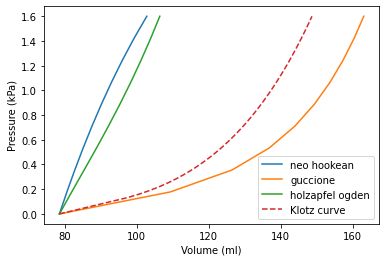

In [5]:
def fix_basal_plane(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    bc = DirichletBC(
        V, Constant((0.0, 0.0, 0.0)), geometry.ffun, geometry.markers["BASE"][0]
    )
    return bc

dirichlet_bc = [fix_basal_plane]

lvp = Constant(0.0)
lv_marker = geometry.markers["ENDO"][0]
lv_pressure = pulse.NeumannBC(traction=lvp, marker=lv_marker, name="lv")
neumann_bc = [lv_pressure]

bcs = pulse.BoundaryConditions(dirichlet=dirichlet_bc, neumann=neumann_bc)

fig, ax = plt.subplots()
for material_model in ["neo_hookean", "guccione", "holzapfel_ogden"]:

    material = setup_material(material_model)
    problem = pulse.MechanicsProblem(geometry, material, bcs)

    pressures = [0.0]
    volumes = [geometry.cavity_volume()]

    for p in np.linspace(0, ED_pressure, 10)[1:]:
        pulse.iterate.iterate(problem, lvp, p)

        pressures.append(p)
        volumes.append(geometry.cavity_volume(u=problem.state.split()[0]))

    ax.plot(volumes, pressures, label=" ".join(material_model.split("_")))

    # Reset pressure
    lvp.assign(Constant(0.0))

vs, ps = klotz_curve()
ax.plot(vs, ps, linestyle="--", label="Klotz curve")
ax.legend(loc="best")
ax.set_xlabel("Volume (ml)")
ax.set_ylabel("Pressure (kPa)")
plt.show()
#plt.savefig("klotz_curve.png")